<a href="https://colab.research.google.com/github/MDSKR/MLDL_paper-review/blob/main/GoogLeNet/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, aux=False):
        super(GoogLeNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.aux = aux
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(7, 7),
                               stride=(2, 2), padding=(3, 3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc_layer = nn.Linear(1024, num_classes)

        if aux:
            self.aux1 = AuxClassifier(512, num_classes)
            self.aux2 = AuxClassifier(528, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        if self.aux:
            aux1 = self.aux1(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.aux:
            aux2 = self.aux2(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc_layer(x)
        

        if self.aux:
            return x, aux1, aux2
            
        return x

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(InceptionBlock, self).__init__()

        self.branch1 = ConvBlock(in_channels, out_1x1, kernel_size=1)
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, red_3x3, kernel_size=1),
            ConvBlock(red_3x3, out_3x3, kernel_size=3, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, red_5x5, kernel_size=1),
            ConvBlock(red_5x5, out_5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_1x1pool, kernel_size=1)
        )
       
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBlock, self).__init__()
        
        self.relu = nn.ReLU(True)
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, **kwargs)

    def forward(self, x):
        return self.relu(self.conv(x))

In [ ]:
class AuxClassifier(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AuxClassifier, self).__init__()

        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = ConvBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        self.fc_layer = nn.Sequential(
            nn.Linear(out_channels, 1024),
            nn.ReLU(True),
            nn.Dropout(p=0.7),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [ ]:
num_classes = 10
batch_size = 128
epochs = 10

learning_rate = 0.001

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)

if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(42)

In [ ]:
model = GoogLeNet(num_classes=num_classes)
model.to(DEVICE)

GoogLeNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): ConvBlock(
    (relu): ReLU(inplace=True)
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionBlock(
    (branch1): ConvBlock(
      (relu): ReLU(inplace=True)
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (branch2): Sequential(
      (0): ConvBlock(
        (relu): ReLU(inplace=True)
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ConvBlock(
        (relu): ReLU(inplace=True)
        (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (branch3): Sequential(
      (0): ConvBlock(
        (relu): ReLU(inplace=True)
        (conv): Conv2d(192, 16, kernel_

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root='data', train=True,
    download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    dataset=trainset, batch_size=batch_size,
    shuffle=True, drop_last=True
)


testset = torchvision.datasets.CIFAR10(
    root='data', train=False,
    download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    dataset=testset, batch_size=batch_size,
    shuffle=False
)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
loss_values = []

for epoch in range(epochs): 
    avg_loss = 0
    total_batch = len(trainloader)

    for X, Y in trainloader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        # X shape (batch_size, channels, width, height)

        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, Y)
        loss.backward()
        optimizer.step()

        avg_loss += loss / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_loss))
    loss_values.append(avg_loss)

print('Learning finished')

Epoch: 0001 cost = 1.960589767
Epoch: 0002 cost = 1.556466818
Epoch: 0003 cost = 1.310517073
Epoch: 0004 cost = 1.119376779
Epoch: 0005 cost = 0.953948855
Epoch: 0006 cost = 0.838714123
Epoch: 0007 cost = 0.730575085
Epoch: 0008 cost = 0.653579533
Epoch: 0009 cost = 0.586531520
Epoch: 0010 cost = 0.532977581
Learning finished


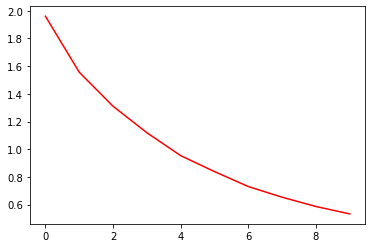

In [ ]:
plt.plot(np.array(loss_values),'r')

In [ ]:
correct = 0.0
total = 0.0

with torch.no_grad():
    for X, Y in testloader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        pred = model(X)

        _, predicted = torch.max(pred.data, 1)

        total += Y.size(0)
        correct += (predicted == Y).sum().item()

print('Acc : %d %%' % ( 100 * correct / total))

Acc : 75 %
